In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import  timedelta
import pandas as pd
import math
import scipy.stats as stats

## Step 1: Defining a Poisson Simulator
To simulate a Poisson process of mean $\lambda t$, we recognize:

1. that the time between arrivals is exponentially distributed with parameter $\frac{1}{\lambda}$.

2. arrivals only increment the process by 1.

3. Our output will be a list of timestamps noting when the random arrival occurred, and another list of the running sum $N(t)$ denoting how many total arrivals
have occurred since the process began.


In [4]:
# poisson process 
from cmath import log
from copy import copy
class Poisson():
    """
    Atributtes
    ----------
    lam : float
        set defect arrival rate lambda.
    period_length : float
        length of HCPP simulation in seconds.
    now : datetime object
        time when class is initiated, referece 0 time. 
    timestamps : list
        list of timestamps of Poisson arrvials.
    process = list
        list of cumulative sum of Poisson process. 

    Methods
    -------
    get_hcpp_arrival()
        Generates Poisson arrival with timestamp.
    get_hcpp_sequence()
        Generates a sequence of Poisson arrivals.
    convert_tstamp_to_sec()
        Converts list of timestamps, self.timestamps to a list of timepoints in seconds.
    mle_est()
        computes MLE estimate for lambda.
    """
    def __init__(self):
        self.lam = 1.0
        self.period_length = 60.0
        self.now = dt.datetime.now()
        self.timestamps = [copy(self.now)]
        self.process = [0]
        
    def get_arrival(self):
        arrival_time = (-1/self.lam)*math.log(np.random.default_rng().uniform())
        self.now += dt.timedelta(seconds = arrival_time)
        return self.now

    def get_sequence(self):
        period_end = copy(self.now) + dt.timedelta(seconds = self.period_length)
        while self.now < period_end:
            arrivaltime = self.get_arrival()
            hcpp_proc = self.process[-1] + 1
            self.timestamps.append(arrivaltime)
            self.process.append(hcpp_proc)
        #self.now = period_end

    def mle_est(self):
        return self.process[-1]/self.period_length

def convert_tstamp_to_sec(timestamps):
    """
    Converts list of timestamps, self.timestamps to a list of timepoints in seconds.
    """
    return [(tstamp - timestamps[0]).total_seconds() for tstamp in timestamps]

## Step 2: Generating a Sequence of Poisson Random Variables (RV)
For $\lambda = 1$, we simulate a Poisson Process for 5 seconds, and plot the results below. 


The mean size and number of the defects were estimated to be 0.6847 defects per second.


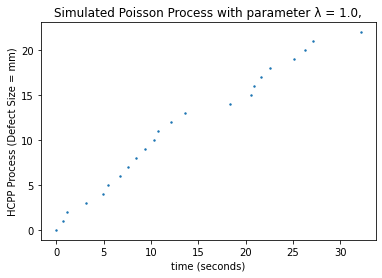

In [5]:
pois_inst = Poisson()
pois_inst.period_length = 30
pois_inst.get_sequence()

print(
    "The mean size and number of the defects were estimated to be {} defects per second.".format(
        round((len(pois_inst.process)-1)/(pois_inst.timestamps[-1]-pois_inst.timestamps[0]).total_seconds(),4)
    ))
timepoints = convert_tstamp_to_sec(pois_inst.timestamps)
arrivals = pois_inst.process

def plot_Poisson_Process(timepoints, arrivals, ticksize=5,params='\u03BB = 1.0,',figtitle="fig1"):
    plt.scatter(x=timepoints, y=arrivals, s=2)
    plt.title("Simulated Poisson Process with parameter {}".format(params))
    plt.xticks(np.arange(min(timepoints), max(timepoints), ticksize))
    plt.xlabel("time (seconds)")
    plt.ylabel("HCPP Process (Defect Size = mm)")
    plt.savefig(figtitle,dpi=100)
    plt.show()

plot_Poisson_Process(timepoints, arrivals, figtitle="fig_1_Poisson_process.png")

## Step 3: Testing Goodness of Fit (GOF) for Simulated HCPP.
To confirm whether the HCPP process follows each individual distribution we use:

MLE estimator and $\chi^2$ Goodness of Fit test for parameter, $\lambda$,

For the $\chi^2$ test where the MLE estimate of the mean No. of defects in a period length $t$ is $\hat \lambda t$ the Hypotheses are:

$\qquad H_0$: The mean rate of order arrival in a 1s increment $ = \hat \lambda t$.

$\qquad H_1$: The mean rate of order arrival in a 1s increment $ \neq \hat \lambda t$.

In [6]:
def compute_gof(poisson_inst,alpha):
    df = pd.Series(poisson_inst.process, index = poisson_inst.timestamps)
    Obs = df.resample('s').count()
    hatlamt = pois_inst.mle_est()
    Exp = [hatlamt]*len(Obs)
    chi_square_test_stat = 0
    for i in range(len(Obs)):
        chi_square_test_stat += (np.square(Obs[i]-Exp[i]))/Exp[i]
    print('chi square value determined by formula : ' + str(chi_square_test_stat))     
    print('chi square critical value at alpha = {}: {}'.format(alpha, stats.chi2.ppf(1-alpha, df=len(Obs)-1)))

#Chi-Sq for Poisson
compute_gof(pois_inst,0.05)

chi square value determined by formula : 20.47272727272728
chi square critical value at alpha = 0.05: 46.19425952027847


### Evaluating Results from GOF tests:
We see that $\chi^2_{stat}$ did not exceed its critical value at an $\alpha = 0.05$.
We can conclude for now that we can

1. simulate a Poisson process $N(t)$ with parameter $\lambda > 0$,

2. We can estimate, and assess goodness of fit of
  
    * the mean no of defects $\hat \lambda t$ using the $\chi^2$ GOF test.

## Step 4: Simulating a Poisson with a changepoint to an increased rate of Defect Arrivals
Next we will simulate a Poisson process that:
    
1. Begins at an initial $\lambda_0 = 1$ Defect/s,
    
2. proceeds with this $\lambda_0$ for 15 seconds,
    
3. changes its rate of Defect arrival to $\lambda_1 = 5$ Defects/s,
    
4. finally proceeds with this $\lambda_0$ for 15 seconds.

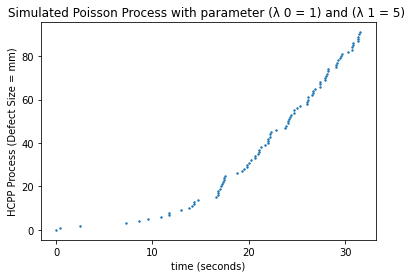

In [7]:
poisson_inst = Poisson()
poisson_inst.period_length = 15
poisson_inst.get_sequence()
lam_est = pois_inst.mle_est
poisson_inst.lam = 5
poisson_inst.get_sequence()
lam_est = poisson_inst.process[-1]/(poisson_inst.timestamps[-1]-poisson_inst.timestamps[0]).total_seconds()
timepoints = convert_tstamp_to_sec(poisson_inst.timestamps)
plot_Poisson_Process(timepoints, poisson_inst.process, ticksize=10,params="(\u03BB 0 = 1) and (\u03BB 1 = 5) ",figtitle="fig_2_changing_poisson.png")

In [8]:
# #Poisson 
compute_gof(poisson_inst,0.05)

chi square value determined by formula : 491.2848484848485
chi square critical value at alpha = 0.05: 44.98534328036513


## Step 6: GOF test results
We see that only the $\chi^2$ statistic exceeded its critical values at an $\alpha = 0.05$.

This creates a new problem! Suppose at some unknown time $\nu$, the rate of Defect arrival changes from $\lambda_0$ to $\lambda_1$.
How do develop a change point detection scheme to identify when this change occurs. 
## Step 7: CUSUM Changepoint Detection Scheme 
Starting again with our Poisson process, $\{N(t)\}_{t\geq0}$ with mean $\lambda_0 t$, where $\lambda_1^+=(1+\epsilon)\lambda_0$, $\lambda_1^-= (1-\epsilon)\lambda_0$, $\{h, \lambda_0, \epsilon \} \in \mathbb{R^+}$ we can define the CUSUM class that generates 6 processes:

1.$ u^+_t (\lambda_0)$; The SPRT process to detect a change from a upward change.

2.$ m^+_t (\lambda_0)$; The running minimum of the upward SPRT process, $u^+_t$.

3.$u^-_t (\lambda_0)$; The SPRT process to detect a change from a downward change.
                
4.$m^-_t (\lambda_0)$; The running minimum of the downward SPRT process, $u^-_t$.

5.$y^+_t (\lambda_0)$; The CUSUM process for an upward change.

6.$y^-_t (\lambda_0)$; The CUSUM process for an downward change.

This CUSUM detection scheme will identify the CUSUM stopping time $\tau$:
$$ \tau = \inf \{ t \geq 0; y^+_t(\lambda_0) \lor y^-_t(\lambda_0) \geq h\}$$

In [9]:
class CUSUM(): 
    def __init__(self, timestamp=dt.datetime(1900,1,1), l0=1.0, epsilon = 0.01, h = 0.0001):
        # from args
        self.l0 = l0
        self.deltatime = 0.0
        self.h = h
        self.epsilon = epsilon
        self.alarm_up,self.alarm_dn = False, False 
        self.timestamp = timestamp
        self.entries = []
        #derived
        self.SPRT_dn, self.SPRT_up = 0.0, 0.0
        self.run_min_dn, self.run_min_up = 0.0, 0.0
        self.CUSUM_dn, self.CUSUM_up = 0.0, 0.0
        self.write_to_df()

    def pmf_poisson(self,lam,deltatime,arrival):
        return (((lam*deltatime) ** arrival)*math.exp(-lam*deltatime))/(arrival)

    def reset_CUSUM(self):
        self.SPRT_dn, self.SPRT_up = 0.0, 0.0
        self.run_min_dn, self.run_min_up = 0.0, 0.0
        self.CUSUM_dn, self.CUSUM_up = 0.0, 0.0
        self.alarm_up,self.alarm_dn = False, False 

    def compute_stats(self, arrival, deltatime, timestamp):
        self.timestamp = timestamp
        l0= copy(self.l0)
        l1p = l0*(1+self.epsilon)
        l1m = l0*(1-self.epsilon)
        if arrival >=1: 
            self.SPRT_up +=  math.log(1+self.epsilon) - (l1p - l0)*deltatime
            self.SPRT_dn += arrival*math.log(1-self.epsilon) - (l1m - l0)*deltatime
        else:
            self.SPRT_up -=  deltatime*(l1p-l0)
            self.SPRT_dn -=  deltatime*(l1m-l0)
        self.run_min_up = min(self.run_min_up, self.SPRT_up)
        self.run_min_dn = min(self.run_min_dn, self.SPRT_dn)
        self.CUSUM_up = self.SPRT_up - self.run_min_up
        self.CUSUM_dn = self.SPRT_dn - self.run_min_dn
    
    def check_alarms(self):
        if self.CUSUM_dn > self.h:
            self.alarm_dn = True
            self.l0 = self.l0*(1-self.epsilon)
        else:
            self.alarm_dn = False

        if self.CUSUM_up > self.h:
            self.alarm_up = True 
            self.l0 = self.l0*(1+self.epsilon)
        else:
            self.alarm_up = False

    
    def write_to_df(self):
        record_to_insert = {
                    'timestamp':self.timestamp,
                    'SPRTup':self.SPRT_up,
                    'runminup':self.run_min_up,
                    'CUSUMup':self.CUSUM_up,
                    'SPRTdn':self.SPRT_dn,
                    'runmindn':self.run_min_dn,
                    'CUSUMdn':self.CUSUM_dn, 
                    'alarmup':self.alarm_up,
                    'alarmdn':self.alarm_dn,
        } 
        self.entries.append(record_to_insert)

    def Update(self, deltatime,arrival, timestamp):
        self.compute_stats( arrival=arrival,deltatime=deltatime,timestamp=timestamp)
        self.check_alarms()
        self.write_to_df()
        if self.alarm_up or self.alarm_dn:
            self.reset_CUSUM()

## Step 8: Trying Out our CUSUM Changepoint Detection Scheme
Lets try to use our change point detection scheme to identify a stopping time $\tau$ where we can say the simulated Poisson no longer has the mean rate $\lambda0$. We will:
    
1. Generate a Poisson process with $\lambda_0 = 1$ Defect/s, that runs for 15 seconds.

2. Record estimates for $\hat \lambda_0 t$ for that initial run.

3. Start recording out CUSUM statistics, 

4. Continue simulating the Poisson process for 15 more seconds,

4. changes the poisson rate of Defect arrival to $\lambda_1 = 5$ Defects/s,
    
5. proceeds with this $\lambda_1$ for 15 seconds.

from this data, we will generate a table of the CUSUM statistics.


In [10]:
## lets try this test
pois_inst = Poisson()
pois_inst.period_length = 15 # 
pois_inst.get_sequence() # End of Step 1
lamtest = pois_inst.mle_est()
pois_inst.epsilon = 0.2
print(lamtest)

pois_inst.__init__()
pois_inst.period_length = 15
pois_inst.get_sequence()
pois_inst.lam=5
pois_inst.get_sequence()
CUSUM_inst = CUSUM(timestamp = pois_inst.timestamps[0], l0=lamtest)
CUSUM_inst.h = 0.05
times = convert_tstamp_to_sec(pois_inst.timestamps)
for i in range(1,len(times)):
    deltatime = times[i] - times[i-1]
    arrival = pois_inst.process[i]-pois_inst.process[i-1]
    CUSUM_inst.Update(arrival=arrival, deltatime=deltatime,timestamp=pois_inst.timestamps[i])
    
df = pd.DataFrame(CUSUM_inst.entries)
df['time'] = convert_tstamp_to_sec(df['timestamp'])

0.9333333333333333


## Step 9 Plotting CUSUM Processes 

In [11]:
def CUSUM_SPRT_runmin_chart(df):
    fig, ax = plt.subplots(3, sharex=True)
    df_alarm = df[df['alarmup'] == True]
    #top graph
    ax[0].title.set_text('Defect CUSUMs Process')
    ax[0].scatter(df['time'], df['CUSUMup'], s=1, color='purple', label='CUSUM up')
    ax[0].scatter(df['time'], df['CUSUMdn'], s=1, color='green', label='CUSUM dn')
    ax[0].bar(df_alarm['time'], max(df['CUSUMup']), width = 0.0000001, label='alarm', color='orange')
    #middle graph
    ax[1].title.set_text('SPRT processes')
    ax[1].scatter(df['time'], df['SPRTup'], s=1, color='red', label='SPRT up')
    ax[1].scatter(df['time'], df['SPRTdn'], s=1, color='blue', label='SPRT dn')
    #bottom graph
    ax[2].title.set_text('running min processes')
    ax[2].scatter(df['time'], df['runminup'], s=1, color='blue', label='runmin up')
    ax[2].scatter(df['time'], df['runmindn'], s=1, color='gold', label='runmin dn')
    #label settings
    ax[0].set_xlabel("Time (s)")
    ax[1].set_xlabel("Time (s)")
    ax[2].set_xlabel("Time (s)")
    plt.xlim(df['time'].iloc[0], df['time'].iloc[-1])
    ax[0].set_ylabel("CUSUM Statistic")
    ax[1].set_ylabel("SPRT Statistic")
    ax[2].set_ylabel("runmin Statistic")
    #display options
    for _ in range(3):
        ax[_].legend(loc= 'center left',bbox_to_anchor=(1,0.5) )
    plt.tight_layout()
    plt.savefig("fig_3_CUSUM_construction.png")
    plt.show()

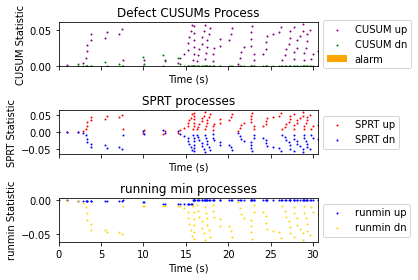

In [12]:
CUSUM_SPRT_runmin_chart(df)

## Appendix:
### Simple log SPRT 
We demonstrate the log SPRT for a sequence of Poisson RVs. This script will

1. Generate a path for a Poisson process at an initial rate $\lambda_0 = 1$ defect/second for period length 1 second.

2. continue simulating the Poisson process at an elevated rate $\lambda_1 = 4$ defects/second for a period of 1 second.

3. Generate a 3 subplot graph illustrating the Poisson process, and SPRT up and SPRT down. 

4. Generate a 3 subplot graph illustrating how the CUSUM is the SPRT minus its running minimum.


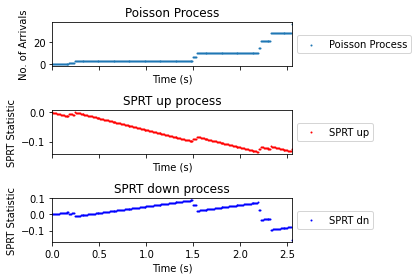

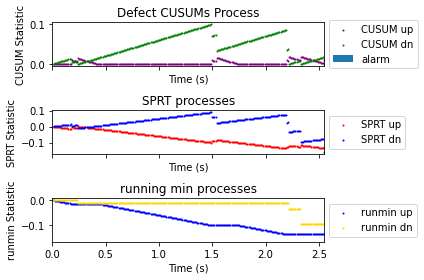

In [16]:
from time import time
pois_inst = Poisson()
# to have a simple poisson
pois_inst.lam = 1
pois_inst.period_length = 1
pois_inst.get_sequence()
pois_inst.lam = 4
pois_inst.get_sequence()
dfs = pd.Series(pois_inst.process,index=pois_inst.timestamps).resample('10ms').sum()
dfs = dfs.cumsum().reset_index()
dfs.columns = ['timestamp', 'Proc']
lam_est = pois_inst.mle_est()
CUSUM_inst = CUSUM(timestamp = dfs['timestamp'].iloc[0], l0=lam_est)
CUSUM_inst.h = 1
CUSUM_inst.epsilon = 0.01
times = convert_tstamp_to_sec(list(dfs['timestamp']))

for i in range(1,len(times)):
    deltatime = times[i] - times[i-1]
    arrival = dfs['Proc'][i] - dfs['Proc'][i-1]
    CUSUM_inst.Update(deltatime,arrival,dfs['timestamp'].iloc[i])
    
df = pd.DataFrame(CUSUM_inst.entries)
df['time'] = convert_tstamp_to_sec(df['timestamp'])
df['Proc'] = dfs['Proc']
def SPRT_chart(df):
    fig, ax = plt.subplots(3, sharex=True)
    #top graph
    ax[0].title.set_text('Poisson Process')
    ax[0].scatter(df['time'], df['Proc'], s=1, label='Poisson Process')
    #middle graph
    ax[1].title.set_text('SPRT up process')
    ax[1].scatter(df['time'], df['SPRTup'], s=1, color='red', label='SPRT up')
    #bottom graph
    ax[2].title.set_text('SPRT down process')
    ax[2].scatter(df['time'], df['SPRTdn'], s=1, color='blue', label='SPRT dn')
    #label settings
    ax[0].set_xlabel("Time (s)")
    ax[1].set_xlabel("Time (s)")
    ax[2].set_xlabel("Time (s)")
    plt.xlim(df['time'].iloc[0], df['time'].iloc[-1])
    ax[0].set_ylabel("No. of Arrivals")
    ax[1].set_ylabel("SPRT Statistic")
    ax[2].set_ylabel("SPRT Statistic")
    #display options
    for _ in range(3):
        ax[_].legend(loc= 'center left',bbox_to_anchor=(1,0.5) )
    plt.tight_layout()
    plt.savefig("fig_2_SPRT_Example.png")
    plt.show()

SPRT_chart(df)
CUSUM_SPRT_runmin_chart(df)